In [1]:
pip install yfinance


In [11]:
pip install statsmodels

In [12]:
pip install arch


[*********************100%%**********************]  1 of 1 completed


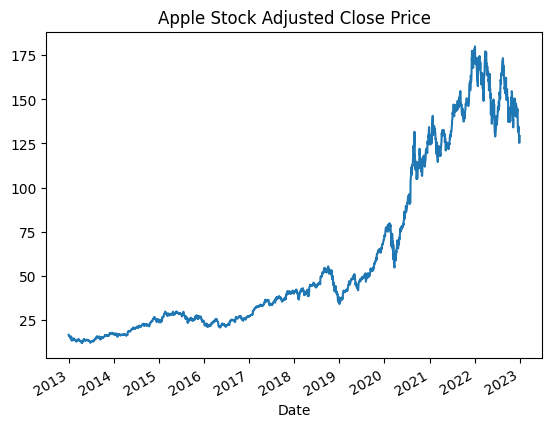

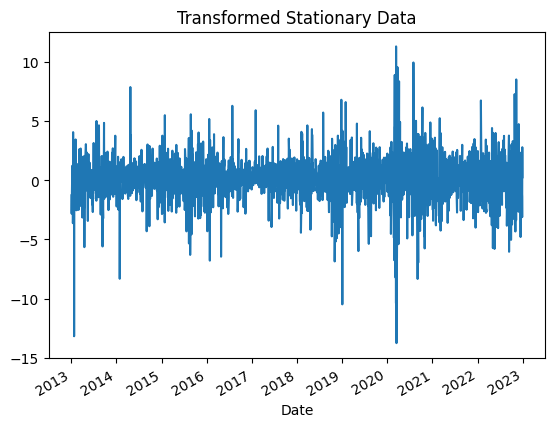

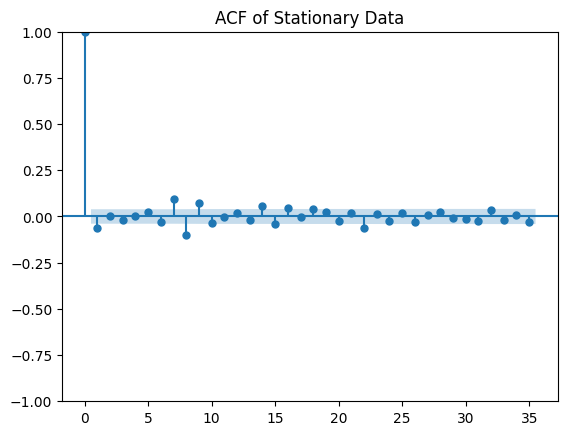

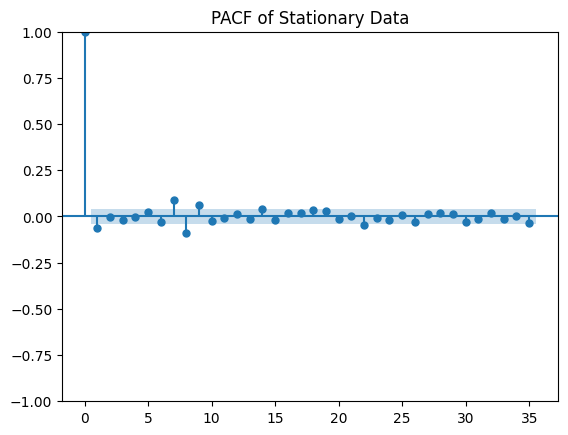

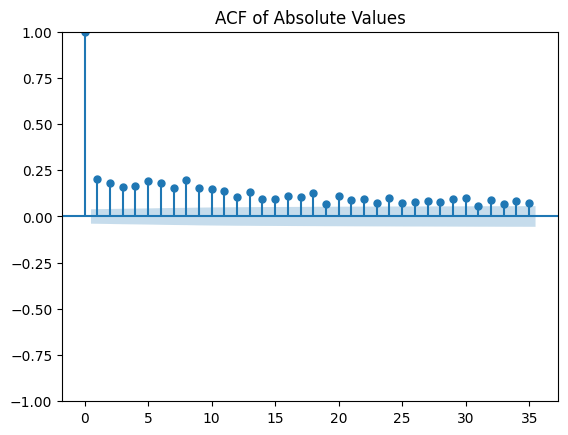

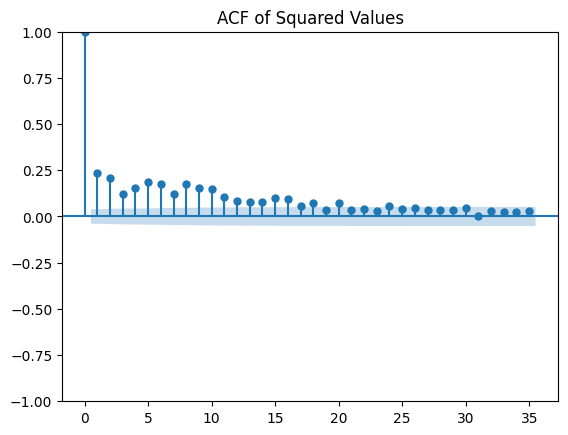

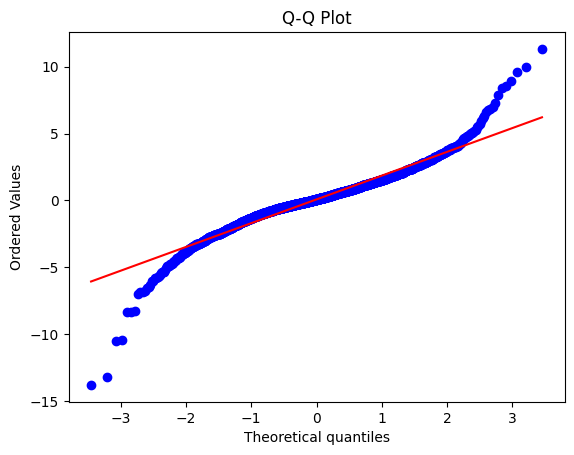

Kurtosis: 6.082393288792238


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import yfinance as yf

# Data Collection
apple_stock_data = yf.download('AAPL', start='2013-01-01', end='2023-01-01')
apple_stock_data['Adj Close'].plot(title='Apple Stock Adjusted Close Price')
plt.show()

# Make Data Stationary
apple_stock_data['Log_Adj_Close'] = np.log(apple_stock_data['Adj Close'])
apple_stock_data['Diff_Log_Adj_Close'] = apple_stock_data['Log_Adj_Close'].diff().dropna() * 100

# Plot the transformed data
apple_stock_data['Diff_Log_Adj_Close'].plot(title='Transformed Stationary Data')
plt.show()

# ACF and PACF Plots
plot_acf(apple_stock_data['Diff_Log_Adj_Close'].dropna())
plt.title('ACF of Stationary Data')
plt.show()

plot_pacf(apple_stock_data['Diff_Log_Adj_Close'].dropna())
plt.title('PACF of Stationary Data')
plt.show()

# Plot ACF and PACF for Absolute and Squared Values
plot_acf(np.abs(apple_stock_data['Diff_Log_Adj_Close'].dropna()))
plt.title('ACF of Absolute Values')
plt.show()

plot_acf(np.square(apple_stock_data['Diff_Log_Adj_Close'].dropna()))
plt.title('ACF of Squared Values')
plt.show()

# Q-Q Plot and Kurtosis
from scipy.stats import probplot, kurtosis

probplot(apple_stock_data['Diff_Log_Adj_Close'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

print("Kurtosis:", kurtosis(apple_stock_data['Diff_Log_Adj_Close'].dropna()))


In [30]:
from sklearn.preprocessing import MinMaxScaler

# Min Max Scaling
data = apple_stock_data['Adj Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [31]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of past days to use for predicting the next day
X, y = create_sequences(scaled_data, time_steps)


In [32]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X_train for the RNN model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [33]:
# Now, you can define the input_shape for your RNN model
input_shape = (X_train.shape[1], 1)  # (time_steps, features)



In [34]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Preprocessing steps (normalization, sequence creation, train-test split)

# Design the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(input_shape)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer

In [35]:


model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16)

# Evaluate the model
predicted_stock_price = model.predict(X_test)



Epoch 1/100
123/123 [==============================] - 5s 10ms/step - loss: 0.0031
Epoch 2/100
123/123 [==============================] - 1s 11ms/step - loss: 8.0039e-04
Epoch 3/100
123/123 [==============================] - 1s 11ms/step - loss: 7.6448e-04
Epoch 4/100
123/123 [==============================] - 1s 10ms/step - loss: 7.0181e-04
Epoch 5/100
123/123 [==============================] - 1s 8ms/step - loss: 6.2943e-04
Epoch 6/100
123/123 [==============================] - 1s 8ms/step - loss: 5.5719e-04
Epoch 7/100
123/123 [==============================] - 1s 8ms/step - loss: 5.9247e-04
Epoch 8/100
123/123 [==============================] - 1s 8ms/step - loss: 4.7499e-04
Epoch 9/100
123/123 [==============================] - 1s 8ms/step - loss: 3.8134e-04
Epoch 10/100
123/123 [==============================] - 1s 8ms/step - loss: 4.6058e-04
Epoch 11/100
123/123 [==============================] - 1s 8ms/step - loss: 4.2808e-04
Epoch 12/100
123/123 [==============================

In [36]:
# Inverse transform predictions and actual values
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
actual_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))


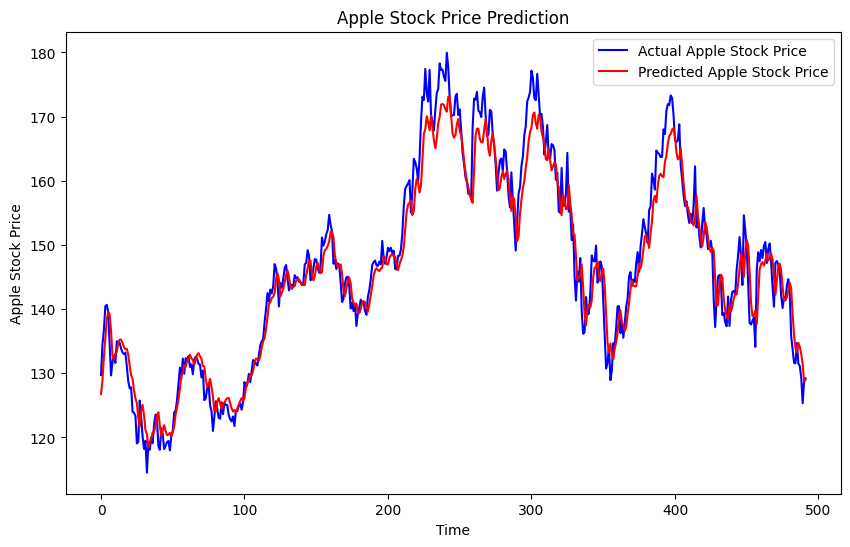

In [37]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


In [38]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
print('Root Mean Squared Error:', rmse)


Root Mean Squared Error: 3.5685728515736415


In [39]:
from tensorflow.keras.layers import GRU

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')


In [40]:
# Stacked RNN Model
stacked_rnn_model = Sequential()
stacked_rnn_model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
stacked_rnn_model.add(LSTM(50, return_sequences=True))
stacked_rnn_model.add(LSTM(50))
stacked_rnn_model.add(Dense(1))

stacked_rnn_model.compile(optimizer='adam', loss='mean_squared_error')


In [41]:
from tensorflow.keras.layers import Bidirectional

# Bidirectional RNN Model
bidirectional_rnn_model = Sequential()
bidirectional_rnn_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
bidirectional_rnn_model.add(Bidirectional(LSTM(50)))
bidirectional_rnn_model.add(Dense(1))

bidirectional_rnn_model.compile(optimizer='adam', loss='mean_squared_error')


In [42]:
# Train the GRU model
gru_model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Compute RMSE
gru_rmse = np.sqrt(mean_squared_error(actual_stock_price, gru_predictions))


Epoch 1/50
62/62 [==============================] - 5s 9ms/step - loss: 0.0057
Epoch 2/50
62/62 [==============================] - 0s 8ms/step - loss: 6.9694e-04
Epoch 3/50
62/62 [==============================] - 0s 8ms/step - loss: 6.4475e-04
Epoch 4/50
62/62 [==============================] - 0s 8ms/step - loss: 6.3636e-04
Epoch 5/50
62/62 [==============================] - 1s 9ms/step - loss: 5.3232e-04
Epoch 6/50
62/62 [==============================] - 1s 11ms/step - loss: 4.5352e-04
Epoch 7/50
62/62 [==============================] - 1s 11ms/step - loss: 5.0182e-04
Epoch 8/50
62/62 [==============================] - 1s 11ms/step - loss: 5.7970e-04
Epoch 9/50
62/62 [==============================] - 1s 14ms/step - loss: 4.4996e-04
Epoch 10/50
62/62 [==============================] - 1s 16ms/step - loss: 3.7440e-04
Epoch 11/50
62/62 [==============================] - 1s 14ms/step - loss: 3.6059e-04
Epoch 12/50
62/62 [==============================] - 1s 9ms/step - loss: 3.5623e-04

In [43]:
# Train the Stacked RNN model
stacked_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict and evaluate
stacked_rnn_predictions = stacked_rnn_model.predict(X_test)
stacked_rnn_predictions = scaler.inverse_transform(stacked_rnn_predictions)

# Compute RMSE
stacked_rnn_rmse = np.sqrt(mean_squared_error(actual_stock_price, stacked_rnn_predictions))


Epoch 1/50
62/62 [==============================] - 7s 12ms/step - loss: 0.0033
Epoch 2/50
62/62 [==============================] - 1s 11ms/step - loss: 2.8605e-04
Epoch 3/50
62/62 [==============================] - 1s 11ms/step - loss: 2.9069e-04
Epoch 4/50
62/62 [==============================] - 1s 11ms/step - loss: 2.7873e-04
Epoch 5/50
62/62 [==============================] - 1s 11ms/step - loss: 2.5161e-04
Epoch 6/50
62/62 [==============================] - 1s 11ms/step - loss: 2.4639e-04
Epoch 7/50
62/62 [==============================] - 1s 11ms/step - loss: 2.7204e-04
Epoch 8/50
62/62 [==============================] - 1s 11ms/step - loss: 2.3412e-04
Epoch 9/50
62/62 [==============================] - 1s 11ms/step - loss: 2.0695e-04
Epoch 10/50
62/62 [==============================] - 1s 11ms/step - loss: 2.3312e-04
Epoch 11/50
62/62 [==============================] - 1s 11ms/step - loss: 2.3327e-04
Epoch 12/50
62/62 [==============================] - 1s 11ms/step - loss: 1.75

In [44]:
# Train the Bidirectional RNN model
bidirectional_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predict and evaluate
bidirectional_rnn_predictions = bidirectional_rnn_model.predict(X_test)
bidirectional_rnn_predictions = scaler.inverse_transform(bidirectional_rnn_predictions)

# Compute RMSE
bidirectional_rnn_rmse = np.sqrt(mean_squared_error(actual_stock_price, bidirectional_rnn_predictions))


Epoch 1/50
62/62 [==============================] - 9s 18ms/step - loss: 0.0039
Epoch 2/50
62/62 [==============================] - 1s 19ms/step - loss: 2.7303e-04
Epoch 3/50
62/62 [==============================] - 1s 19ms/step - loss: 1.9919e-04
Epoch 4/50
62/62 [==============================] - 1s 18ms/step - loss: 1.8619e-04
Epoch 5/50
62/62 [==============================] - 1s 13ms/step - loss: 1.5653e-04
Epoch 6/50
62/62 [==============================] - 1s 14ms/step - loss: 1.3433e-04
Epoch 7/50
62/62 [==============================] - 1s 13ms/step - loss: 1.2985e-04
Epoch 8/50
62/62 [==============================] - 1s 13ms/step - loss: 1.1882e-04
Epoch 9/50
62/62 [==============================] - 1s 13ms/step - loss: 1.4502e-04
Epoch 10/50
62/62 [==============================] - 1s 13ms/step - loss: 1.3671e-04
Epoch 11/50
62/62 [==============================] - 1s 14ms/step - loss: 1.1601e-04
Epoch 12/50
62/62 [==============================] - 1s 13ms/step - loss: 1.00

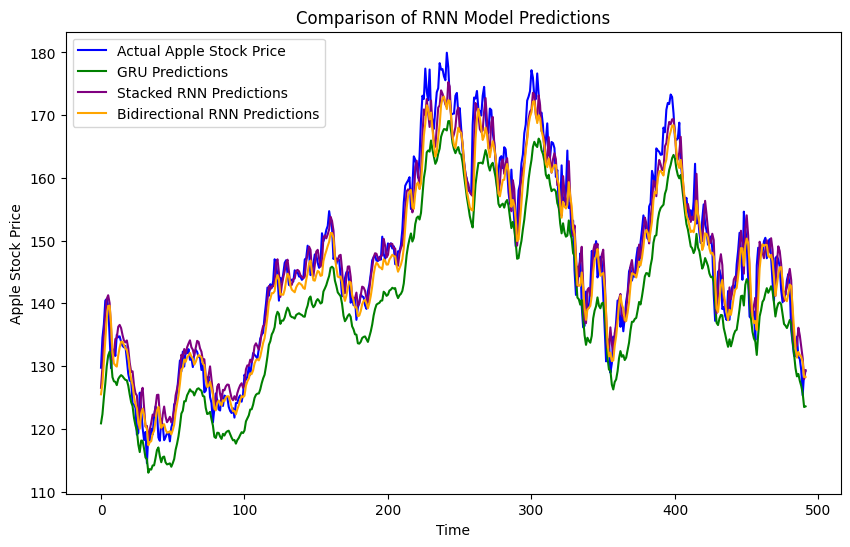

In [45]:
#plotting all graphs on one
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, color='blue', label='Actual Apple Stock Price')
plt.plot(gru_predictions, color='green', label='GRU Predictions')
plt.plot(stacked_rnn_predictions, color='purple', label='Stacked RNN Predictions')
plt.plot(bidirectional_rnn_predictions, color='orange', label='Bidirectional RNN Predictions')
plt.title('Comparison of RNN Model Predictions')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


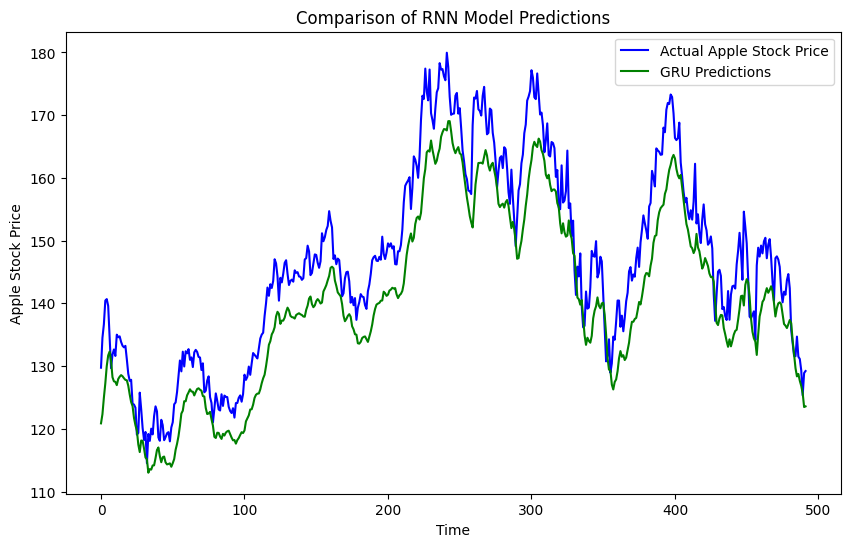

In [46]:
#gru prediction comparison
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, color='blue', label='Actual Apple Stock Price')
plt.plot(gru_predictions, color='green', label='GRU Predictions')
plt.title('Comparison of RNN Model Predictions')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

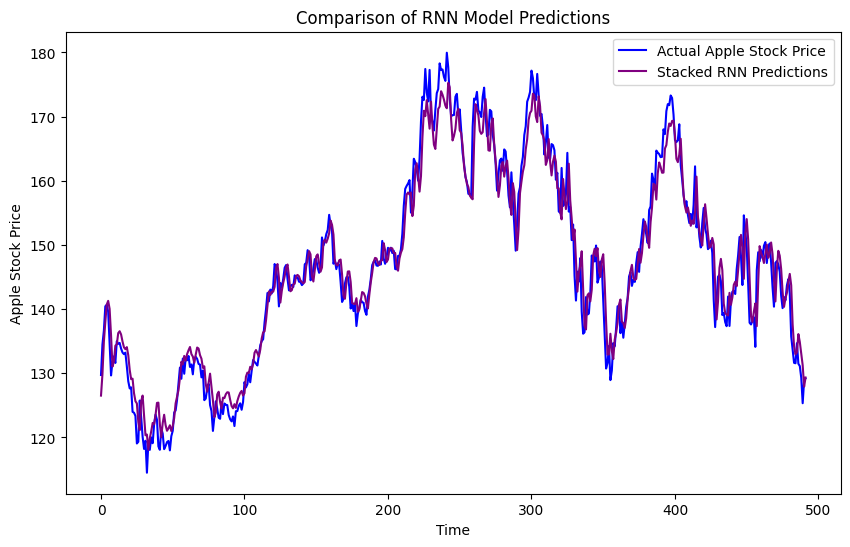

In [47]:
#stacked rnn comparison
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, color='blue', label='Actual Apple Stock Price')
plt.plot(stacked_rnn_predictions, color='purple', label='Stacked RNN Predictions')
plt.title('Comparison of RNN Model Predictions')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [48]:
print(f'GRU RMSE: {gru_rmse}')
print(f'Stacked RNN RMSE: {stacked_rnn_rmse}')
print(f'Bidirectional RNN RMSE: {bidirectional_rnn_rmse}')


GRU RMSE: 7.3732700145366925
Stacked RNN RMSE: 3.270990365800178
Bidirectional RNN RMSE: 3.7275735151117955


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Data Collection
apple_stock_data = yf.download('AAPL', start='2013-01-01', end='2023-01-01')
features = ['Open', 'High', 'Low', 'Volume']  # Excluding 'Close' and 'Adj Close'

# Make Data Stationary (on 'Close' price)
apple_stock_data['Log_Close'] = np.log(apple_stock_data['Close'])
apple_stock_data['Diff_Log_Close'] = apple_stock_data['Log_Close'].diff().dropna()

# Preprocess other features
feature_data = apple_stock_data[features]
feature_data = feature_data[1:]  # Align with the differenced data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(feature_data)

# Combine with stationary 'Diff_Log_Close'
target_data = apple_stock_data['Diff_Log_Close'].values[1:].reshape(-1, 1)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_data)

# Combine features and target to create sequences
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(time_steps, len(target)):
        X.append(features[i-time_steps:i])
        y.append(target[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_features, scaled_target, time_steps)



[*********************100%%**********************]  1 of 1 completed


In [51]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X_train and X_test for the RNN model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Model architecture
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the RNN model
input_shape = (X_train.shape[1], X_train.shape[2])
rnn_model = build_model(input_shape)

# Train the model
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predictions
predicted_stock_price = rnn_model.predict(X_test)




Epoch 1/50
56/56 [==============================] - 5s 24ms/step - loss: 0.0392 - val_loss: 0.0499
Epoch 2/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 3/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0083 - val_loss: 0.0099
Epoch 4/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0130
Epoch 5/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0070 - val_loss: 0.0159
Epoch 6/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 7/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 8/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0189
Epoch 9/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0066 - val_loss: 0.0127
Epoch 10/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0168
Epoch 11/50
56

In [17]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00


In [21]:
import pandas as pd
import yfinance as yf

# Download and process stock data
apple_stock_data = yf.download('AAPL', start='2013-01-01', end='2023-01-01')

# Count the number of NA values in the dataset
na_count = apple_stock_data.isna().sum()
print(na_count)


[*********************100%%**********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Data Collection
apple_stock_data = yf.download('AAPL', start='2013-01-01', end='2023-01-01')

# Making Data Stationary
apple_stock_data['Log_Adj_Close'] = np.log(apple_stock_data['Adj Close'])
apple_stock_data['Diff_Log_Adj_Close'] = apple_stock_data['Log_Adj_Close'].diff().dropna()

# Ensure the stationary series does not contain non-finite values
apple_stock_data = apple_stock_data[np.isfinite(apple_stock_data['Diff_Log_Adj_Close'])]

apple_stock_data.index = pd.DatetimeIndex(apple_stock_data.index).to_period('D')

# Fit ARIMA Model
model_arima = ARIMA(apple_stock_data['Diff_Log_Adj_Close'], order=(1, 1, 1))
results_arima = model_arima.fit()

# Extract and Handle Residuals from ARIMA Model
arima_residuals = results_arima.resid
arima_residuals = arima_residuals.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

# Ensure residuals are finite
arima_residuals = arima_residuals[np.isfinite(arima_residuals)]

# Rescale ARIMA residuals
rescaled_residuals = arima_residuals * 100

# Fit GARCH Model on rescaled data
model_garch = arch_model(rescaled_residuals, vol='Garch', p=1, q=1, rescale=False)
results_garch = model_garch.fit()

# Display the summary of GARCH model
print(results_garch.summary())


[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 16079.380655240657
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5480.368967904101
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1351009988.4219706
Iteration:      4,   Func. Count:     27,   Neg. LLF: 7550.923686391215
Iteration:      5,   Func. Count:     33,   Neg. LLF: 4928.501693483086
Iteration:      6,   Func. Count:     39,   Neg. LLF: 16105.185026750754
Iteration:      7,   Func. Count:     45,   Neg. LLF: 4890.440052929915
Iteration:      8,   Func. Count:     51,   Neg. LLF: 4866.01718465191
Iteration:      9,   Func. Count:     56,   Neg. LLF: 4865.911277964131
Iteration:     10,   Func. Count:     61,   Neg. LLF: 4865.908581267951
Iteration:     11,   Func. Count:     66,   Neg. LLF: 4865.908568154304
Iteration:     12,   Func. Count:     71,   Neg. LLF: 4865.908565289325
Iteration:     13,   Func. Count:     75,   Neg. LLF: 4865.908565

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

length_of_data = len(apple_stock_data) - 1  # Adjusting for differencing

# Truncate or extend ARIMA predictions to match the length of the time series data
arima_predictions = results_arima.predict(start=1, end=length_of_data)

# Truncate or extend GARCH predictions
# Assuming garch_forecast.variance.values[-1, :] is the correct way to extract predictions
if len(garch_volatility) > length_of_data:
    garch_volatility = garch_volatility[:length_of_data]
elif len(garch_volatility) < length_of_data:
    # Handle case where GARCH predictions are fewer than needed
    # This could involve extending the array or revising the GARCH forecasting approach
    pass

# Combine features
features = np.column_stack((apple_stock_data['Log_Adj_Close'].values[1:], arima_predictions, garch_volatility))

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Reshape for LSTM: [samples, time steps, features]
scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, apple_stock_data['Log_Adj_Close'].values[1:], test_size=0.2, random_state=42)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predictions
predicted_stock_price = model.predict(X_test)


Epoch 1/100
63/63 [==============================] - 5s 7ms/step - loss: 12.5937
Epoch 2/100
63/63 [==============================] - 0s 8ms/step - loss: 1.6909
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0373
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0249
Epoch 5/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0170
Epoch 6/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0123
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 9/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 10/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0080
Epoch 11/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 12/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 13/100
63/63 [================

16/16 [==============================] - 0s 6ms/step


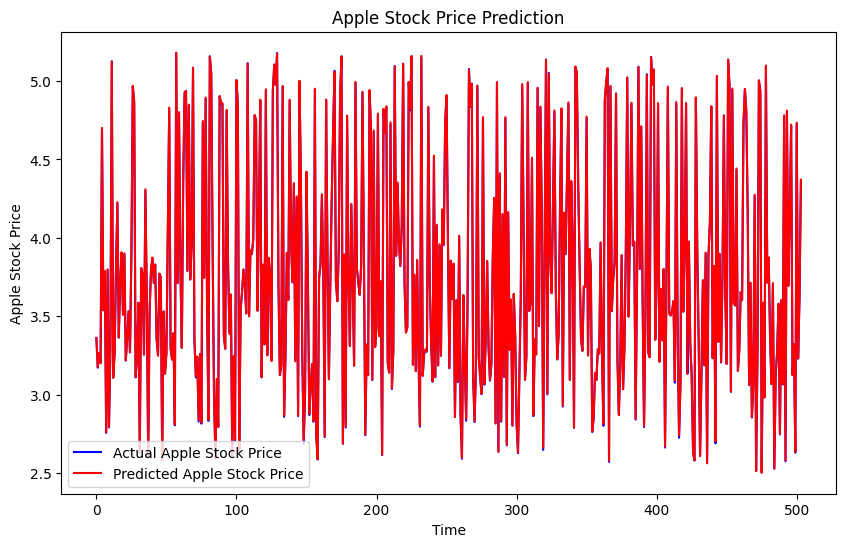

In [37]:
import matplotlib.pyplot as plt

real_stock_price = y_test
predicted_stock_price = model.predict(X_test)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


16/16 [==============================] - 0s 4ms/step


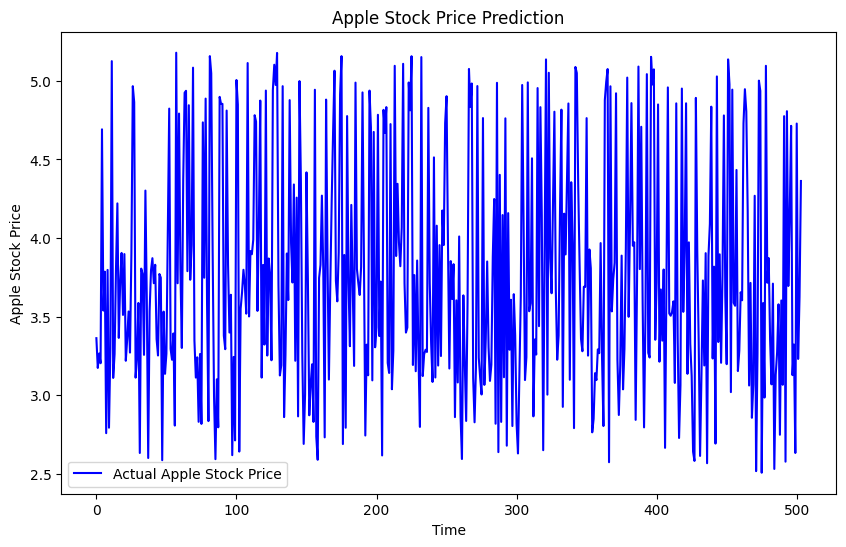

In [38]:
import matplotlib.pyplot as plt

real_stock_price = y_test
predicted_stock_price = model.predict(X_test)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.004696886588864072
